In [1]:
from torch.utils.data import Dataset 
from PIL import Image
import torch
import glob
import albumentations as A
import cv2
import numpy as np
from torchvision import transforms
root = '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks'
class Breast(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.msks = glob.glob(root + '/*_tumor.png')
        normal = [
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case045.png',
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case061.png',
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case209.png',
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case213.png',
        ]
        du = glob.glob(root+ '/*other*.png')
        self.imgs = [path for path in glob.glob(root+ '/*') if path not in (self.msks+du+normal)]


        # Ensure that the number of images and masks match
        assert len(self.imgs) == len(self.msks), "Number of images and masks don't match" 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        # Remove the 4th channel (if present)
        img = img.convert('RGB') if img.mode == 'RGBA' else img
        msk = msk.convert('L')  # Convert mask to grayscale (optional)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

ModuleNotFoundError: No module named 'torch'

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.dv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[3] - x1.size()[3]
        diffY = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, [
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNetEfficientNetB7(nn.Module):
    def __init__(self, n_classes):
        super(UNetEfficientNetB7, self).__init__()
        self.encoder = models.efficientnet_b7(pretrained=True).features

        self.doubleconv = DoubleConv(3, 64)
        self.down1 = self.encoder[:2]   # Output: 32 channels
        self.down2 = self.encoder[2:4]  # Output: 48 channels
        self.down3 = self.encoder[4:6]  # Output: 80 channels
        self.down4 = self.encoder[6:8]  # Output: 224 channels
        self.down5 = self.encoder[8:]   # Output: 640 channels

        self.up1 = Up(640 + 224, 256)
        self.up2 = Up(256 + 80, 128)
        self.up3 = Up(128 + 48, 64)
        self.up4 = Up(64 + 32, 32)
        self.up5 = Up(32 + 64, 32)

        self.out = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.doubleconv(x)
        x2 = self.down1(x)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)

        logits = self.out(x)
        return logits

model = UNetEfficientNetB7(n_classes=1)
print(model)


/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /media/mountHDD2/chuyenmt/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|████████████████████████████████████████████████████████████████████████████████| 255M/255M [04:18<00:00, 1.03MB/s]


UNetEfficientNetB7(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNo

In [15]:
from torchvision import models

# Load the EfficientNet B7 model
efficientnet_b7 = models.efficientnet_b7(pretrained=True)

# Print the structure of the features
print(efficientnet_b7.features)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
root = '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks'
class Breast(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.msks = sorted(glob.glob(root + '/*_tumor.png'))
        normal = [
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case045.png',
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case061.png',
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case209.png',
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case213.png',
        ]
        du = glob.glob(root+ '/*other*.png')
        self.imgs = sorted([path for path in glob.glob(root+ '/*') if path not in (self.msks+du+normal)])


        # Ensure that the number of images and masks match
        assert len(self.imgs) == len(self.msks), "Number of images and masks don't match"

        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        # Remove the 4th channel (if present)
        img = img.convert('RGB') if img.mode == 'RGBA' else img
        msk = msk.convert('L')  # Convert mask to grayscale

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [17]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),

    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = Breast(root =root,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

252


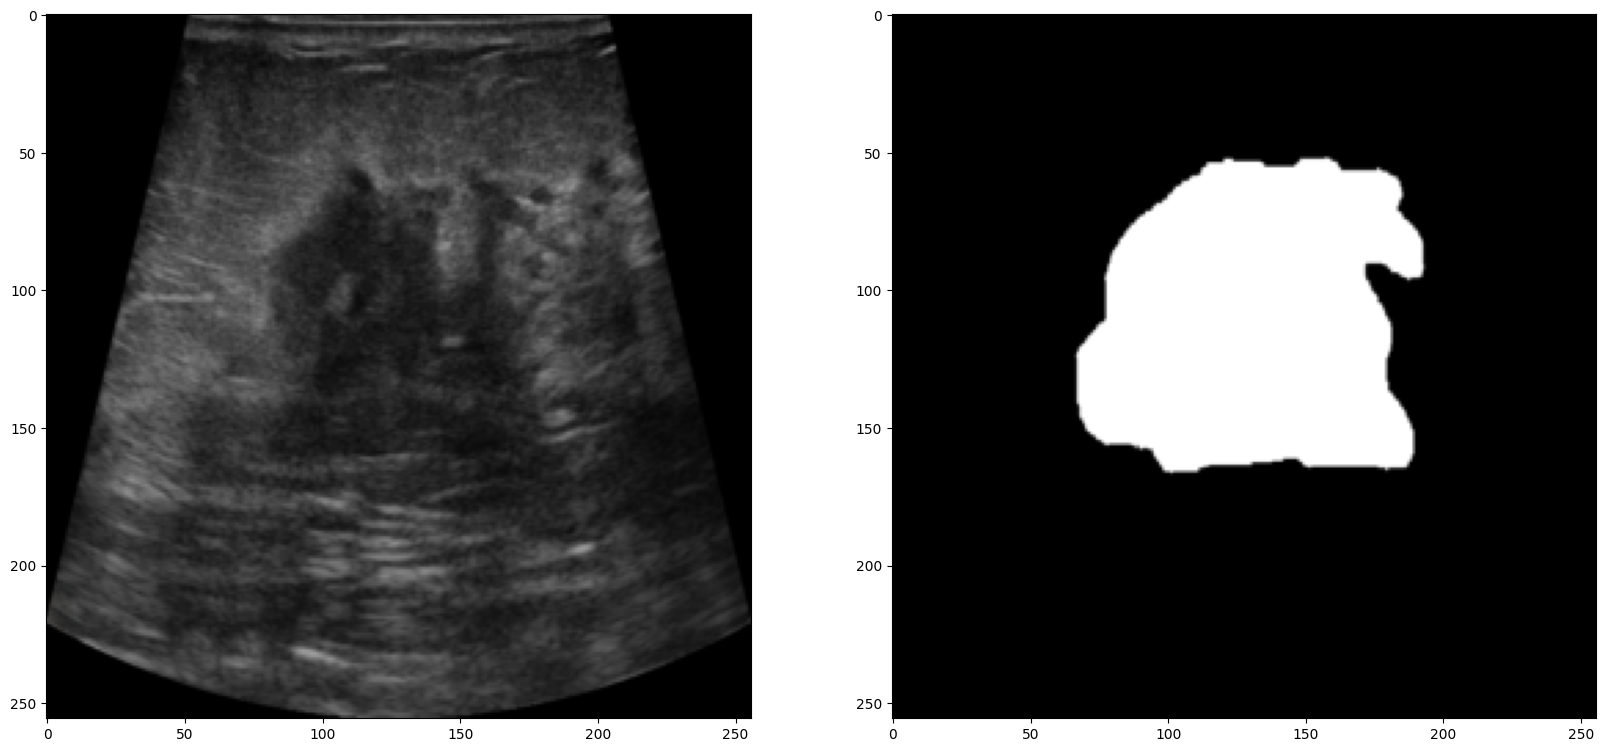

In [18]:

img, msk = Data_transfered[220]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20)) #tạo một figure chứa hai axes (ax1 và ax2) được sắp xếp theo hàng ngang với kích thước 20x20 inches
ax1.imshow(img.permute(1, -1, 0).numpy()) #Phương thức permute(1, -1, 0) được sử dụng để thay đổi chiều của tensor ,.numpy() chuyển đổi tensor thành mảng NumPy
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [21]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))
print(len(Data_transfered))

Training Samples: 202
Testing Samples: 50
252


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.dv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[3] - x1.size()[3]
        diffY = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, [
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNetEfficientNetB7(nn.Module):
    def __init__(self, n_classes):
        super(UNetEfficientNetB7, self).__init__()
        self.encoder = models.efficientnet_b7(pretrained=True).features

        self.doubleconv = DoubleConv(3, 64)
        self.down1 = self.encoder[:2]   # Output: 32 channels
        self.down2 = self.encoder[2:4]  # Output: 48 channels
        self.down3 = self.encoder[4:6]  # Output: 80 channels
        self.down4 = self.encoder[6:8]  # Output: 224 channels
        self.down5 = self.encoder[8:]   # Output: 640 channels

        self.up1 = Up(3200, 256)
        self.up2 = Up(480, 128)
        self.up3 = Up(208, 64)
        self.up4 = Up(64 + 32, 32)
        self.up5 = Up(32 + 64, 32)

        self.out = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.doubleconv(x)
        x2 = self.down1(x)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)

        logits = self.out(x)
        return logits

model = UNetEfficientNetB7(n_classes=1)
print(model)


UNetEfficientNetB7(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNo

In [34]:

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 30

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.CrossEntropyLoss()

In [35]:
old_loss = 1e26
best_dct = None
last_dst = None

train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img
        train_mask = train_mask

        train_gen_mask = model(train_img)
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img
            valid_mask = valid_mask

            valid_gen_img = model(valid_img)
            valid_loss = loss_fn(valid_gen_img, valid_mask)

            va_total_loss += valid_loss.item()

    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    train_losses.append(mean_train_loss)
    valid_losses.append(mean_valid_loss)
    
    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()

    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")

model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.06it/s]


Epoch: 0 - TrainLoss: 0.2927838550640805 - ValidLoss: 0.45497882187366484


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.10it/s]


Epoch: 1 - TrainLoss: 0.17624604473314662 - ValidLoss: 0.16122363708913326


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch: 2 - TrainLoss: 0.15519611129887623 - ValidLoss: 0.1818769271671772


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch: 3 - TrainLoss: 0.14082973881965816 - ValidLoss: 0.36238934740424156


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch: 4 - TrainLoss: 0.13347737815710578 - ValidLoss: 1.6129705292731524


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch: 5 - TrainLoss: 0.12377996755634794 - ValidLoss: 1.3530882605165244


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.93it/s]


Epoch: 6 - TrainLoss: 0.11113111508807333 - ValidLoss: 1.7460313342511653


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch: 7 - TrainLoss: 0.10287739425934482 - ValidLoss: 0.3507368962466717


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch: 8 - TrainLoss: 0.09064806280381019 - ValidLoss: 0.5312448991835117


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch: 9 - TrainLoss: 0.08239564428677654 - ValidLoss: 0.28927844397723673


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch: 10 - TrainLoss: 0.07362946651248943 - ValidLoss: 0.5780452218651772


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.80it/s]


Epoch: 11 - TrainLoss: 0.07196082087178336 - ValidLoss: 0.36006162874400616


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.03it/s]


Epoch: 12 - TrainLoss: 0.06391240058393025 - ValidLoss: 0.49831277180463074


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch: 13 - TrainLoss: 0.058616920323618274 - ValidLoss: 0.5533355574682355


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch: 14 - TrainLoss: 0.055983122253772055 - ValidLoss: 0.840307698585093


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch: 15 - TrainLoss: 0.051541829689193776 - ValidLoss: 0.6753788261115551


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch: 16 - TrainLoss: 0.051261941003290436 - ValidLoss: 0.7304161488264799


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch: 17 - TrainLoss: 0.04643218965721455 - ValidLoss: 0.6597837128490209


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.91it/s]


Epoch: 18 - TrainLoss: 0.04444878887256036 - ValidLoss: 0.8222403527051211


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.89it/s]


Epoch: 19 - TrainLoss: 0.041493547746063314 - ValidLoss: 0.7417148073017598


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.93it/s]


Epoch: 20 - TrainLoss: 0.03974855262186784 - ValidLoss: 0.8005723220854998


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch: 21 - TrainLoss: 0.03902900929212349 - ValidLoss: 0.6800087638199329


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch: 22 - TrainLoss: 0.038465732132259865 - ValidLoss: 0.8318741712719202


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch: 23 - TrainLoss: 0.035844003705602916 - ValidLoss: 0.7750750733166933


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.92it/s]


Epoch: 24 - TrainLoss: 0.0349396374168815 - ValidLoss: 0.8366484056413174


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch: 25 - TrainLoss: 0.03557593493012361 - ValidLoss: 0.9097387948632241


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch: 26 - TrainLoss: 0.034144117128067086 - ValidLoss: 0.6748772270232439


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch: 27 - TrainLoss: 0.03335077739044065 - ValidLoss: 1.0748888485133647


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch: 28 - TrainLoss: 0.0337454541609392 - ValidLoss: 0.8189271848648787


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.93it/s]

Epoch: 29 - TrainLoss: 0.03409228299163503 - ValidLoss: 1.0046834080666303


<All keys matched successfully>

In [36]:
torch.save(best_dct, '/media/mountHDD2/chuyenmt/BrEaST//model_efficientnetb7_Unet_26_7.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BME DESIGN/model_unet_11_7.pth'))


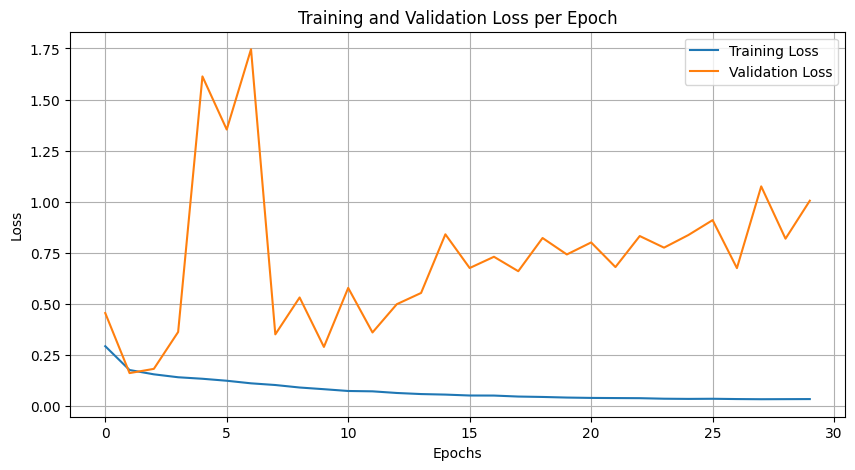

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, jaccard_score
from tqdm import tqdm

# Hàm tính toán Dice coefficient
def dice_coefficient(pred, target):
    smooth = 1e-6
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

model.eval()
test_total_loss = 0
test_total_dice = 0
test_total_iou = 0
num_batches = len(test_dl)

with torch.no_grad():
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img
        test_mask = test_mask

        test_gen_mask = model(test_img)
        test_loss = loss_fn(test_gen_mask, test_mask)

        test_total_loss += test_loss.cpu().item()
        test_total_dice += dice_coefficient(test_gen_mask, test_mask).cpu().item()

        # Chuyển đổi dự đoán thành nhị phân
        binary_test_gen_mask = (torch.sigmoid(test_gen_mask) > 0.5).float()

        # Ensure both arrays are binary by thresholding test_mask
        binary_test_mask = (test_mask > 0.5).float()

        test_total_iou += jaccard_score(binary_test_mask.cpu().numpy().flatten(),
                                       binary_test_gen_mask.cpu().numpy().flatten())

mean_test_loss = test_total_loss / num_batches
mean_test_dice = test_total_dice / num_batches
mean_test_iou = test_total_iou / num_batches

print(f"Test Loss: {mean_test_loss}")
print(f"Test Dice Coefficient: {mean_test_dice}")
print(f"Test IoU: {mean_test_iou}")

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.21it/s]

Test Loss: 1.0046834080666303
Test Dice Coefficient: 0.34687060989406165
Test IoU: 0.24536959786957524


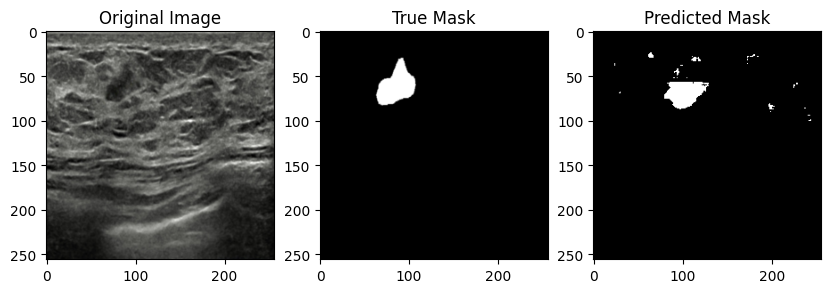

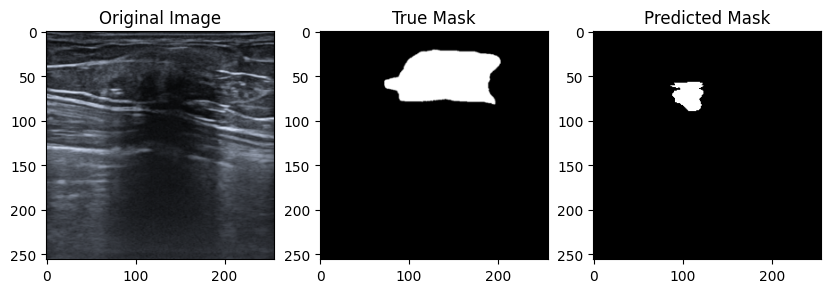

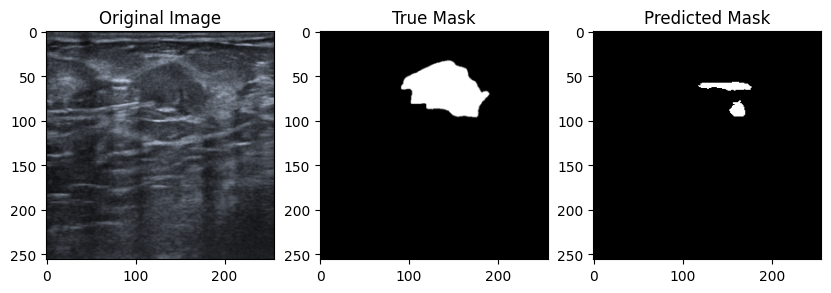

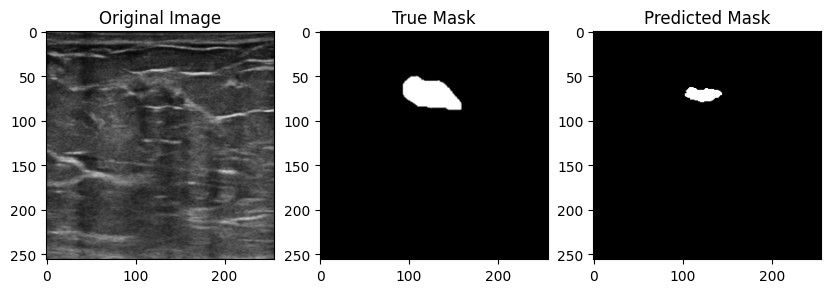

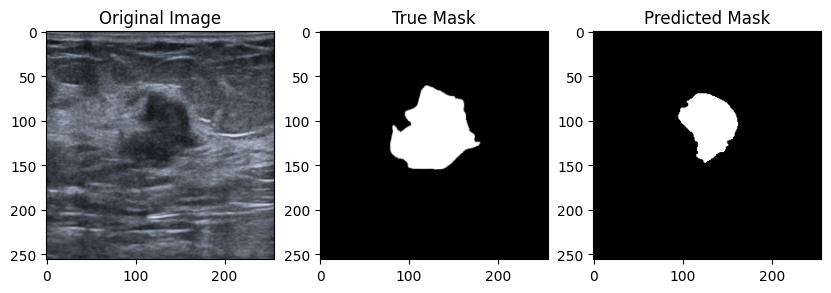

In [39]:
import matplotlib.pyplot as plt

# Hiển thị ảnh gốc, nhãn thực tế và dự đoán
n = 5  # Số lượng ảnh muốn hiển thị
test_iter = iter(test_dl)
for _ in range(n):
    test_img, test_mask = next(test_iter)
    test_gen_mask = model(test_img)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_img.squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask.squeeze().cpu().numpy(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    binary_test_gen_mask = (torch.sigmoid(test_gen_mask) > 0.5).float()
    plt.imshow(binary_test_gen_mask.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()


In [ ]:
import os, sys
from typing import *
import cv2
from PIL import Image
from rich.progress import track
import numpy as np
import argparse
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
import albumentations as A

 
class WithAubumentations(Dataset):
    def __init__(self, root ):
 
  
        self.resize = A.Compose(
            [
                A.Resize(256, 256),
            ]
        )

        self.aug_transforms = A.Compose(
            [
                A.HorizontalFlip(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.5, border_mode = cv2.BORDER_CONSTANT),
            ]
        )

        self.norm = A.Compose(
            [
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )
        self._segs = sorted(glob.glob(root + '/*_tumor.png'))
        normal = [
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case045.png',
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case061.png',
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case209.png',
            '/media/mountHDD2/chuyenmt/BrEaST/BrEaST-Lesions_USG-images_and_masks/case213.png',
        ]
        du = glob.glob(root+ '/*other*.png')
        self._images = sorted([path for path in glob.glob(root+ '/*') if path not in (self.msks+du+normal)])


        print("Data Set Setting Up")
        print(len(self._images),len(self._segs))

    @staticmethod
    def process_mask(x):
        uniques = torch.unique(x, sorted = True)
        if uniques.shape[0] > 3:
            x[x == 0] = uniques[2]
            uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        
        x = x.to(dtype=torch.long)
        onehot = F.one_hot(x.squeeze(1), 7).permute(0, 3, 1, 2)[0].float()
        return onehot

    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self._images[idx]).convert("RGB"))
        mask = np.array(Image.open(self._segs[idx]))

        resized = self.resize(image = image, mask = mask)
 
        transformed = self.aug_transforms(image = resized['image'], mask = resized['mask'])
        transformed_img = self.norm(image=transformed["image"])["image"]
        transformed_mask = transformed["mask"]


        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1).float()
        torch_mask = torch.from_numpy(transformed_mask).unsqueeze(-1).permute(-1, 0, 1).float()

        return torch_img, self.process_mask(torch_mask)
Data_transfered = WithAubumentations(root= data_dir)


In [ ]:
# Vẽ đồ thị loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()